In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
import os
from pathlib import Path
import pandas as pd

train_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Training")

image_dirs = [
    train_dir / "[image]cow_seg_1",
    train_dir / "[image]cow_seg_2",
    train_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

data = pd.DataFrame(filepaths, columns=['Filepath'])

data['File ID'] = [Path(filepath).stem.split('_')[-1] for filepath in data['Filepath']]
data['Grade'] = [int(Path(filepath).parent.stem[-1]) for filepath in data['Filepath']]

print(data)


                                               Filepath File ID  Grade
0     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003479      1
1     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001252      1
2     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003445      1
3     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003323      1
4     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001534      1
...                                                 ...     ...    ...
2995  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008184      3
2996  /Users/jeesuppark/Downloads/aihub-meat-image/T...  012335      3
2997  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008423      3
2998  /Users/jeesuppark/Downloads/aihub-meat-image/T...  010287      3
2999  /Users/jeesuppark/Downloads/aihub-meat-image/T...  004594      3

[3000 rows x 3 columns]


In [3]:
import json
from pathlib import Path
import pandas as pd

train_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Training")

label_dirs = [
    train_dir / "[label]cow_seg_1",
    train_dir / "[label]cow_seg_2",
    train_dir / "[label]cow_seg_3"
]

points_data = pd.DataFrame(columns=['File ID', 'Points'])

for label_dir in label_dirs:
    # Get all JSON file paths in the label_dir
    json_files = label_dir.glob("*.json")

    for json_file in json_files:
        # Load the JSON file
        with open(json_file, 'r') as f:
            label_json = json.load(f)

        # Extract the points from the label JSON
        points = label_json['label_info']['shapes'][0]['points']
        grade = label_json['label_info']['shapes'][0]['grade']

        # Convert the points to a string representation
        points_str = str(points)

        # Extract the last ID from the file name
        file_id = json_file.stem.split('_')[-1]

        # Create a temporary DataFrame with the current data
        temp_df = pd.DataFrame({
            'File ID': [file_id], 
            'Points': [points_str],
            'Grade': [grade]
        })

        # Concatenate the temporary DataFrame with the main points_data DataFrame
        points_data = pd.concat([points_data, temp_df], ignore_index=True)

print(points_data)


     File ID                                             Points Grade
0     002858  [[1701.3333333333335, 1843.0], [1681.333333333...     1
1     004125  [[548.2379862700228, 761.8306636155605], [548....     1
2     000166  [[808.1440443213296, 763.8781163434902], [808....     1
3     000189  [[612.3112128146452, 720.6407322654462], [527....     1
4     000473  [[354.5576707726765, 751.2653975363942], [341....     1
...      ...                                                ...   ...
2995  004562  [[797.0637119113572, 910.6925207756232], [805....     3
2996  004831  [[373.91812865497076, 679.2982456140351], [371...     3
2997  011625  [[765.6292906178488, 951.7620137299771], [767....     3
2998  002009  [[738.2717989002357, 953.401413982718], [750.8...     3
2999  009645  [[628.0886426592797, 932.8531855955678], [647....     3

[3000 rows x 3 columns]


In [4]:
merged_data = pd.merge(data, points_data, on='File ID', how='inner')
merged_data = merged_data.drop('Grade_y', axis=1)
merged_data = merged_data.rename(columns={'Grade_x': 'Grade'})
print(merged_data)


                                               Filepath File ID  Grade  \
0     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003479      1   
1     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001252      1   
2     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003445      1   
3     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003323      1   
4     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001534      1   
...                                                 ...     ...    ...   
2995  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008184      3   
2996  /Users/jeesuppark/Downloads/aihub-meat-image/T...  012335      3   
2997  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008423      3   
2998  /Users/jeesuppark/Downloads/aihub-meat-image/T...  010287      3   
2999  /Users/jeesuppark/Downloads/aihub-meat-image/T...  004594      3   

                                                 Points  
0     [[346.1919504643963, 726.5634674922602], [361..

In [5]:
import cv2
import numpy as np

# Iterate over the rows of the data DataFrame
for index, row in merged_data.iterrows():
    # Load the image
    image_path = row['Filepath']
    image = cv2.imread(image_path)

    # Create a blank mask image of the same size as the original image
    mask = np.zeros_like(image)

    # Get the points from the current row
    points = eval(row['Points'])

    # Convert the points to a NumPy array of integer coordinates
    points = np.array(points, dtype=np.int32)

    # Create a mask for the current points
    cv2.fillPoly(mask, [points], (255, 255, 255))

    # Perform the bitwise AND operation between the image and the mask
    masked_image = cv2.bitwise_and(image, mask)

    cv2.imwrite(image_path, masked_image)

print("Masked images applied to the data successfully.")


Masked images applied to the data successfully.


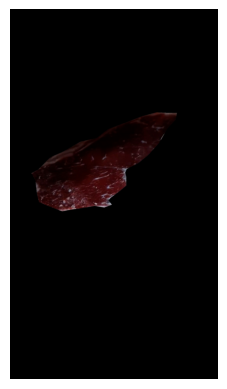

In [6]:
def visualize_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize a specific image by providing its file path
image_path = merged_data['Filepath'][2421]  # Replace 0 with the index of the desired image
visualize_image(image_path)

In [7]:
valid_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Validation")

image_dirs = [
    valid_dir / "[image]cow_seg_1",
    valid_dir / "[image]cow_seg_2",
    valid_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

valid_data = pd.DataFrame(filepaths, columns=['Filepath'])

valid_data['File ID'] = [Path(filepath).stem.split('_')[-1] for filepath in valid_data['Filepath']]
valid_data['Grade'] = [int(Path(filepath).parent.stem[-1]) for filepath in valid_data['Filepath']]

print(valid_data)


                                               Filepath File ID  Grade
0     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069878      1
1     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070440      1
2     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069887      1
3     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070871      1
4     /Users/jeesuppark/Downloads/aihub-meat-image/V...  071206      1
...                                                 ...     ...    ...
1495  /Users/jeesuppark/Downloads/aihub-meat-image/V...  076499      3
1496  /Users/jeesuppark/Downloads/aihub-meat-image/V...  072172      3
1497  /Users/jeesuppark/Downloads/aihub-meat-image/V...  070765      3
1498  /Users/jeesuppark/Downloads/aihub-meat-image/V...  069552      3
1499  /Users/jeesuppark/Downloads/aihub-meat-image/V...  077036      3

[1500 rows x 3 columns]


In [8]:
import json
from pathlib import Path
import pandas as pd

valid_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Validation")

label_dirs = [
    valid_dir / "[label]cow_seg_1",
    valid_dir / "[label]cow_seg_2",
    valid_dir / "[label]cow_seg_3"
]

valid_label = pd.DataFrame(columns=['File ID', 'Points'])

for label_dir in label_dirs:
    # Get all JSON file paths in the label_dir
    json_files = label_dir.glob("*.json")

    for json_file in json_files:
        # Load the JSON file
        with open(json_file, 'r') as f:
            label_json = json.load(f)

        # Extract the points from the label JSON
        points = label_json['label_info']['shapes'][0]['points']
        grade = label_json['label_info']['shapes'][0]['grade']

        # Convert the points to a string representation
        points_str = str(points)

        # Extract the last ID from the file name
        file_id = json_file.stem.split('_')[-1]

        # Create a temporary DataFrame with the current data
        temp_df = pd.DataFrame({
            'File ID': [file_id], 
            'Points': [points_str],
            'Grade': [grade]
        })

        # Concatenate the temporary DataFrame with the main points_data DataFrame
        valid_label = pd.concat([valid_label, temp_df], ignore_index=True)

print(valid_label)


     File ID                                             Points Grade
0     069946  [[557.5383176605486, 702.7858107682314], [478....     1
1     070634  [[497.8947368421052, 625.7097288676235], [456....     1
2     070458  [[182.10526315789468, 697.7574370709382], [161...     1
3     070663  [[655.7894736842104, 1036.4302059496567], [653...     1
4     070399  [[384.3213296398892, 708.4764542936286], [376....     1
...      ...                                                ...   ...
1495  074158  [[577.3037857802401, 706.6297322253001], [503....     3
1496  072825  [[243.00751879699246, 570.0075187969925], [243...     3
1497  075460  [[111.28526856121874, 405.7941248002985], [121...     3
1498  074230  [[691.8005540166205, 777.7285318559556], [708....     3
1499  070336  [[298.2043343653251, 344.0897832817338], [298....     3

[1500 rows x 3 columns]


In [9]:
merged_valid_data = pd.merge(valid_data, valid_label, on='File ID', how='inner')
merged_valid_data = merged_valid_data.drop('Grade_y', axis=1)
merged_valid_data = merged_valid_data.rename(columns={'Grade_x': 'Grade'})
print(merged_valid_data)


                                               Filepath File ID  Grade  \
0     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069878      1   
1     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070440      1   
2     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069887      1   
3     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070871      1   
4     /Users/jeesuppark/Downloads/aihub-meat-image/V...  071206      1   
...                                                 ...     ...    ...   
1495  /Users/jeesuppark/Downloads/aihub-meat-image/V...  076499      3   
1496  /Users/jeesuppark/Downloads/aihub-meat-image/V...  072172      3   
1497  /Users/jeesuppark/Downloads/aihub-meat-image/V...  070765      3   
1498  /Users/jeesuppark/Downloads/aihub-meat-image/V...  069552      3   
1499  /Users/jeesuppark/Downloads/aihub-meat-image/V...  077036      3   

                                                 Points  
0     [[377.03703703703695, 561.5594541910331], [279.

In [10]:
import cv2
import numpy as np

# Iterate over the rows of the data DataFrame
for index, row in merged_valid_data.iterrows():
    # Load the image
    image_path = row['Filepath']
    image = cv2.imread(image_path)
    
    # Create a blank mask image of the same size as the original image
    mask = np.zeros_like(image)
    # Get the points from the current row
    points = eval(row['Points'])
    
    # Convert the points to a NumPy array of integer coordinates
    points = np.array(points, dtype=np.int32)
    # Create a mask for the current points
    cv2.fillPoly(mask, [points], (255, 255, 255))
    # Perform the bitwise AND operation between the image and the mask
    masked_image = cv2.bitwise_and(image, mask)

    cv2.imwrite(image_path, masked_image)
    
    

print("Masked images applied to the data successfully.")


Masked images applied to the data successfully.


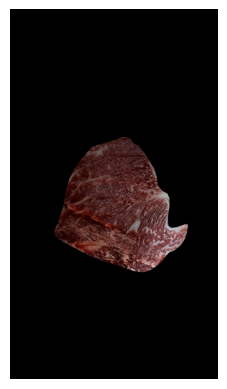

In [11]:
# Visualize a specific image by providing its file path
id = 21 # Replace with the index of the desired image
image_path = merged_valid_data['Filepath'][id]  
visualize_image(image_path)

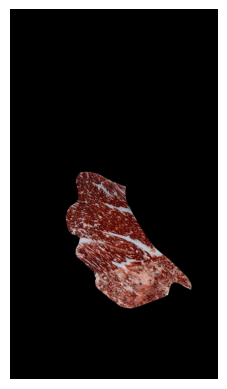

(1920, 1080)


In [17]:
img_path = merged_data['Filepath'][id]
image = cv2.imread(img_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width = image.shape[:2]

# Calculate the desired width and height
desired_width = width  # Replace with your desired width
desired_height = int(height * (desired_width / width))

# Calculate the top-left corner coordinates to crop the center region
start_x = (width - desired_width) // 2
start_y = (height - desired_height) // 2

# Crop the image
cropped_image = image[start_y:start_y + desired_height, start_x:start_x + desired_width]

# Resize the cropped image to the desired width
resized_image = cv2.resize(cropped_image, (desired_width, desired_height))

# Overwrite the original image with the cropped image
cv2.imwrite(img_path, resized_image)

# Reload the modified image
image = cv2.imread(img_path)
visualize_image(img_path)

height, width = image.shape[:2]
print(image.shape[:2])

In [18]:
pip install pytorch_pretrained_vit

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11115 sha256=bb71fbfc6fa97b12aa361a353227cd003bd235aa54870200ffb14947e6e7d569
  Stored in directory: /Users/jeesuppark/Library/Caches/pip/wheels/20/16/21/ea75e637c84ae6e3d2c4a546a1f28d19df704ff95ddb77bd47
Successfully built pytorch_pretrained_vit
Note: you may need to restart the kernel to use updated packages.
